In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet169

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def shuffle_in_place(a, b, c):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

In [5]:
CLASS_DICT = {
    0: 'car',
    1: 'trash container',
    2: "bicycle"
}

def decode_class(cl_index):
    return CLASS_DICT[cl_index]

In [15]:
# load the data and print some important information about it
X_orig = np.load('/content/drive/MyDrive/CS230 /Data/X_TEST.npy')
Y_orig = np.load('/content/drive/MyDrive/CS230 /Data/Y_TEST.npy')
classes = np.load('/content/drive/MyDrive/CS230 /Data/Y_TEST_classes.npy')

# resizing for the gradients loss fn
Y_shape = Y_orig.shape
Y_orig = np.resize(Y_orig, (Y_shape[0], Y_shape[1], Y_shape[2], 1))

# shuffle the toyset
shuffle_in_place(X_orig, Y_orig, classes)

X_test = X_orig
Y_test = Y_orig
classes_test = classes
classes_test = tf.reshape(tf.one_hot(classes_test, 3), shape=[X_orig.shape[0], 3])

# normalize
X_test = tf.convert_to_tensor(X_test/255)
Y_test = tf.convert_to_tensor(Y_test/1000)

print ("number of training examples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_test.shape))
print ("Y_train shape: " + str(Y_test.shape))
print("class vector shape: " + str(classes_test.shape))

# set the max depth value for the loss fn (should be the same as from the training set, hard coded-imported that value here)
MAX_DEPTH = 12.085999999999999
print(f'MAX_DEPTH = {MAX_DEPTH}')

# set the cmap
cmap='plasma_r'

number of training examples = 371
X_train shape: (371, 96, 128, 3)
Y_train shape: (371, 96, 128, 1)
class vector shape: (371, 3)
MAX_DEPTH = 12.085999999999999


bicycle


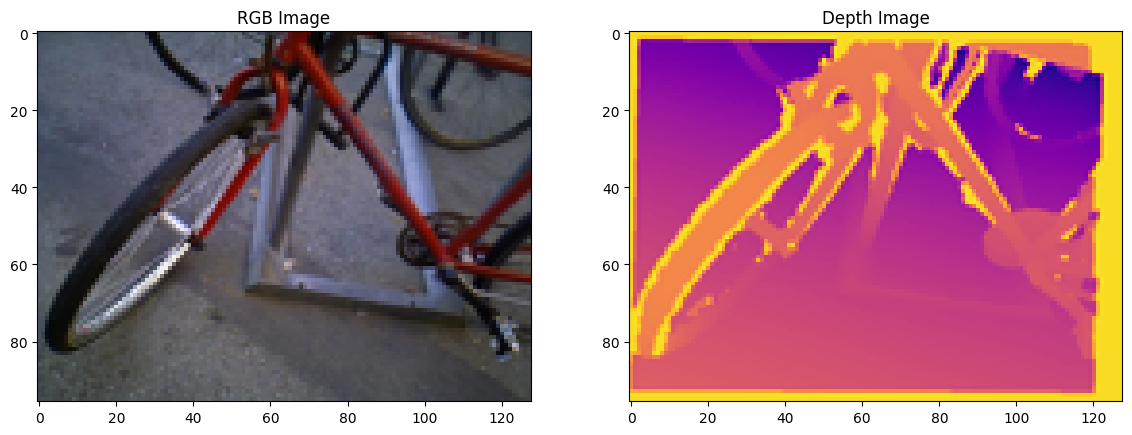

In [8]:
# look at various images
image_num = 252
fig, arr = plt.subplots(1, 2, figsize=(14, 7))
arr[0].imshow(X_test[image_num])
arr[0].set_title(f'RGB Image')
arr[1].imshow(Y_test[image_num], cmap=cmap)
arr[1].set_title('Depth Image')
print(decode_class(classes_test[image_num][0]))

In [12]:
def calculate_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=K.max(y_true)-K.min(y_true))

In [9]:
def UpScaleBlock(expansive_input, concat_layer, concat=True, n_filters=32):
    '''
    Convolutional upsampling block

    Arguments:
        expansive_input -- input to be upsampled
        concat_layer -- skip connection from the previous layer
        concat (bool) -- whether or not to include the skip
        n_filters -- # of filters
    Returns:
        reluB -- upsampled relu output tensor
    '''

    up = tfl.UpSampling2D(size=(2, 2), interpolation='bilinear')(expansive_input)
    if concat:
        concatenated = tfl.concatenate([up, concat_layer], axis=-1)
        convA = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(concatenated)
    else:
        convA = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(up)

    bnA = tfl.BatchNormalization()(convA)
    reluA = tfl.LeakyReLU(negative_slope=0.2)(bnA)
    convB = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(reluA)
    bnB = tfl.BatchNormalization()(convB)
    reluB = tfl.LeakyReLU(negative_slope=0.2)(convB)

    return reluB

In [10]:
def loss_function(y_true, y_pred, lmbda=0.1, max_depth_value=MAX_DEPTH):
    '''
    Custom loss Fn

    Arguments:
        y_true, y_pred -- according to tf, ground truth and model prediction
        lmbda -- MAE loss weight (0.1 default)
        max_depth_value -- max depth occurring anywhere in the image
    Returns
        Weighted sum of the 3 loss terms
    '''

    # point-wise depth loss (MAE term)
    l_MAE = K.mean(K.abs(y_pred - y_true), axis=-1)

    # gradient loss
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # l_ssim term
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, max_depth_value)) * 0.5, 0, 1)

    return 0.85*l_ssim + 0.9*K.mean(l_edges) + lmbda*K.mean(l_MAE)

In [11]:
def M_Unet(input_size=(96, 128, 3), n_filters=32, fine_tune=False, fine_tune_at=None):
    '''
    Transfer learning model. Call the base model DenseNet169, feed its output to our upsampling layers

    Arguments:
        inputs_size -- size of input
        n_filters -- # of filters
        fine_tune (bool) -- whether to unlock layers of the base for fine tuning
        fine_tune_at (int) -- how many layers to unlock. ignored if fine_tune=False
    Returns:
        tf.keras.Model instance
    '''

    # load the base model and freeze it
    inputs = tfl.Input(input_size)

    base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=input_size, input_tensor=inputs)
    base_model.trainable=False

    # option to fine tune the model
    if fine_tune:
        base_model.trainable=True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

    # grab the names of the concat layers
    concat_layers = ['pool1', 'pool2_pool', 'pool3_pool', 'conv1_relu']

    mid = base_model(inputs, training=False)

    # u net for the depth estimation
    bottleneck = tfl.Conv2D(n_filters*16, kernel_size=1, padding="same")(mid)
    ublock1 = UpScaleBlock(bottleneck, base_model.get_layer(concat_layers[2]).output, n_filters=n_filters*8)
    ublock2 = UpScaleBlock(ublock1, base_model.get_layer(concat_layers[1]).output, n_filters=n_filters*4)
    ublock3 = UpScaleBlock(ublock2, base_model.get_layer(concat_layers[0]).output, n_filters=n_filters*2)
    ublock4 = UpScaleBlock(ublock3, base_model.get_layer(concat_layers[3]).output, n_filters=n_filters)
    ublock5 = UpScaleBlock(ublock4, None, concat=False)

    outputs_depth = tfl.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='linear', name='depth')(ublock5)

    # classification layer for common objects
    poolblock = tfl.GlobalAveragePooling2D()(mid)
    dropout = tfl.Dropout(0.2)(poolblock)

    outputs_classifier = tfl.Dense(3, activation='softmax', name='classes')(dropout)

    model = tf.keras.Model(inputs=inputs, outputs={'depth': outputs_depth, 'classes': outputs_classifier})
    print(inputs, '\n', outputs_depth, '\n',  outputs_classifier)
    return model

In [16]:
model = M_Unet(n_filters=(832//16))
model.summary(show_trainable=True, line_length=100)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
<KerasTensor shape=(None, 96, 128, 3), dtype=float32, sparse=False, name=keras_tensor> 
 <KerasTensor shape=(None, 96, 128, 1), dtype=float32, sparse=False, name=keras_tensor_636> 
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_639>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape         ┃       Param # ┃ Connected to         ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer) │ (None, 96, 128, 3)   │             0 │ -                    │    -    │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ zero_padding2d           │ (None, 102, 134, 3)  │             0 │ input_layer[0][0]    │    -    │
│ (ZeroPadding2D)          │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv1_conv (Conv2D)      │ (None, 48, 64, 64)   │         9,408 │ zero_padding2d[0][0] │    N    │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv1_bn                 │ (None, 48, 64, 64)   │           256 │ conv1_conv[0][0]     │    N    │
│ (BatchNormalization)     │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv1_relu (Activation)  │ (None, 48, 64, 64)   │             0 │ conv1_bn[0][0]       │    -    │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ zero_padding2d_1         │ (None, 50, 66, 64)   │             0 │ conv1_relu[0][0]     │    -    │
│ (ZeroPadding2D)          │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ pool1 (MaxPooling2D)     │ (None, 24, 32, 64)   │             0 │ zero_padding2d_1[0]… │    -    │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2_block1_0_bn        │ (None, 24, 32, 64)   │           256 │ pool1[0][0]          │    N    │
│ (BatchNormalization)     │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2_block1_0_relu      │ (None, 24, 32, 64)   │             0 │ conv2_block1_0_bn[0… │    -    │
│ (Activation)             │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2_block1_1_conv      │ (None, 24, 32, 128)  │         8,192 │ conv2_block1_0_relu… │    N    │
│ (Conv2D)                 │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2_block1_1_bn        │ (None, 24, 32, 128)  │           512 │ conv2_block1_1_conv… │    N    │
│ (BatchNormalization)     │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2_block1_1_relu      │ (None, 24, 32, 128)  │             0 │ conv2_block1_1_bn[0… │    -    │
│ (Activation)             │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2_block1_2_conv      │ (None, 24, 32, 32)   │        36,864 │ conv2_block1_1_relu… │    N    │
│ (Conv2D)                 │                      │               │                      │         │
├──────────────────────────┼──────────────────────┼───────────────┼──────────────────────┼─────────┤
│ conv2_block1_concat      │ (None, 24, 32, 96)   │             0 │ pool1[0][0],         │    -    │
│ (Concatenate)            │                      │          

 Total params: 21,556,124 (82.23 MB)

 Trainable params: 8,911,620 (34.00 MB)

 Non-trainable params: 12,644,504 (48.23 MB)

In [17]:
# load in the weights
model.load_weights('/content/drive/MyDrive/CS230 /Model Weights/model-11-30-2024-continuation-00.weights.h5')

In [18]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)

model.compile(optimizer=optimizer,
              loss={
                  'depth': loss_function,
                  'classes': 'categorical_crossentropy'
              },
              metrics={
                  'depth': ['mae', calculate_ssim],
                  'classes': [tf.metrics.CategoricalAccuracy, 'precision', 'recall', 'f1_score']
              })

In [19]:
metrics = model.evaluate(X_test,
               {
                   'depth': Y_test,
                   'classes': classes_test
               })

12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 7s/step - classes_categorical_accuracy: 0.9777 - classes_f1_score: 0.9771 - classes_loss: 0.0833 - classes_precision: 0.9777 - classes_recall: 0.9777 - depth_calculate_ssim: 0.6841 - depth_loss: 0.3722 - depth_mae: 0.4318 - loss: 0.4561


0.3636380434036255


In [ ]:
def show_predictions(images, ground_truth, nums=[0, 1, 2]):
    '''
    Cute wrapper to pick an image, show its GT and prediction. Use on train or test set

    Arguments:
    images -- RGB image
    ground_truth -- GT depth
    num -- index of the image you want to predict

    TODO: add functionality for showing predictions of images without GT

    Returns:
    Nothing. Shows plt.figure on call
    '''

    fig, arr = plt.subplots(len(nums), 3, figsize=(15, len(nums)*4))

    for i in range(len(nums)):
      test_predict = np.reshape(images[nums[i]], (1, 96, 128, 3))
      test_truth = np.reshape(ground_truth[nums[i]], (1, 96, 128, 1))
      prediction = model.predict(test_predict)

      arr[i, 0].imshow(images[nums[i]])
      arr[i, 0].set_title('Original Image')

      vmax, vmin = np.max(ground_truth[nums[i]]), np.min(ground_truth[nums[i]])

      arr[i, 1].imshow(ground_truth[nums[i]], cmap=cmap, vmax=vmax, vmin=vmin)
      arr[i, 1].set_title('Ground Truth Map')

      arr[i, 2].imshow(prediction['depth'][0, :, :, :], cmap=cmap, vmax=vmax, vmin=vmin)
      arr[i, 2].set_title('Predicted Map')
      class_prediction = np.argmax(prediction['classes'][0])

      print(f'the model thinks this image number {nums[i]} is a {decode_class(class_prediction)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
the model thinks this image number 334 is a trash container
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
the model thinks this image number 1 is a trash container
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
the model thinks this image number 252 is a trash container
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
the model thinks this image number 3 is a trash container
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
the model thinks this image number 50 is a trash container
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
the model thinks this image number 10 is a trash container


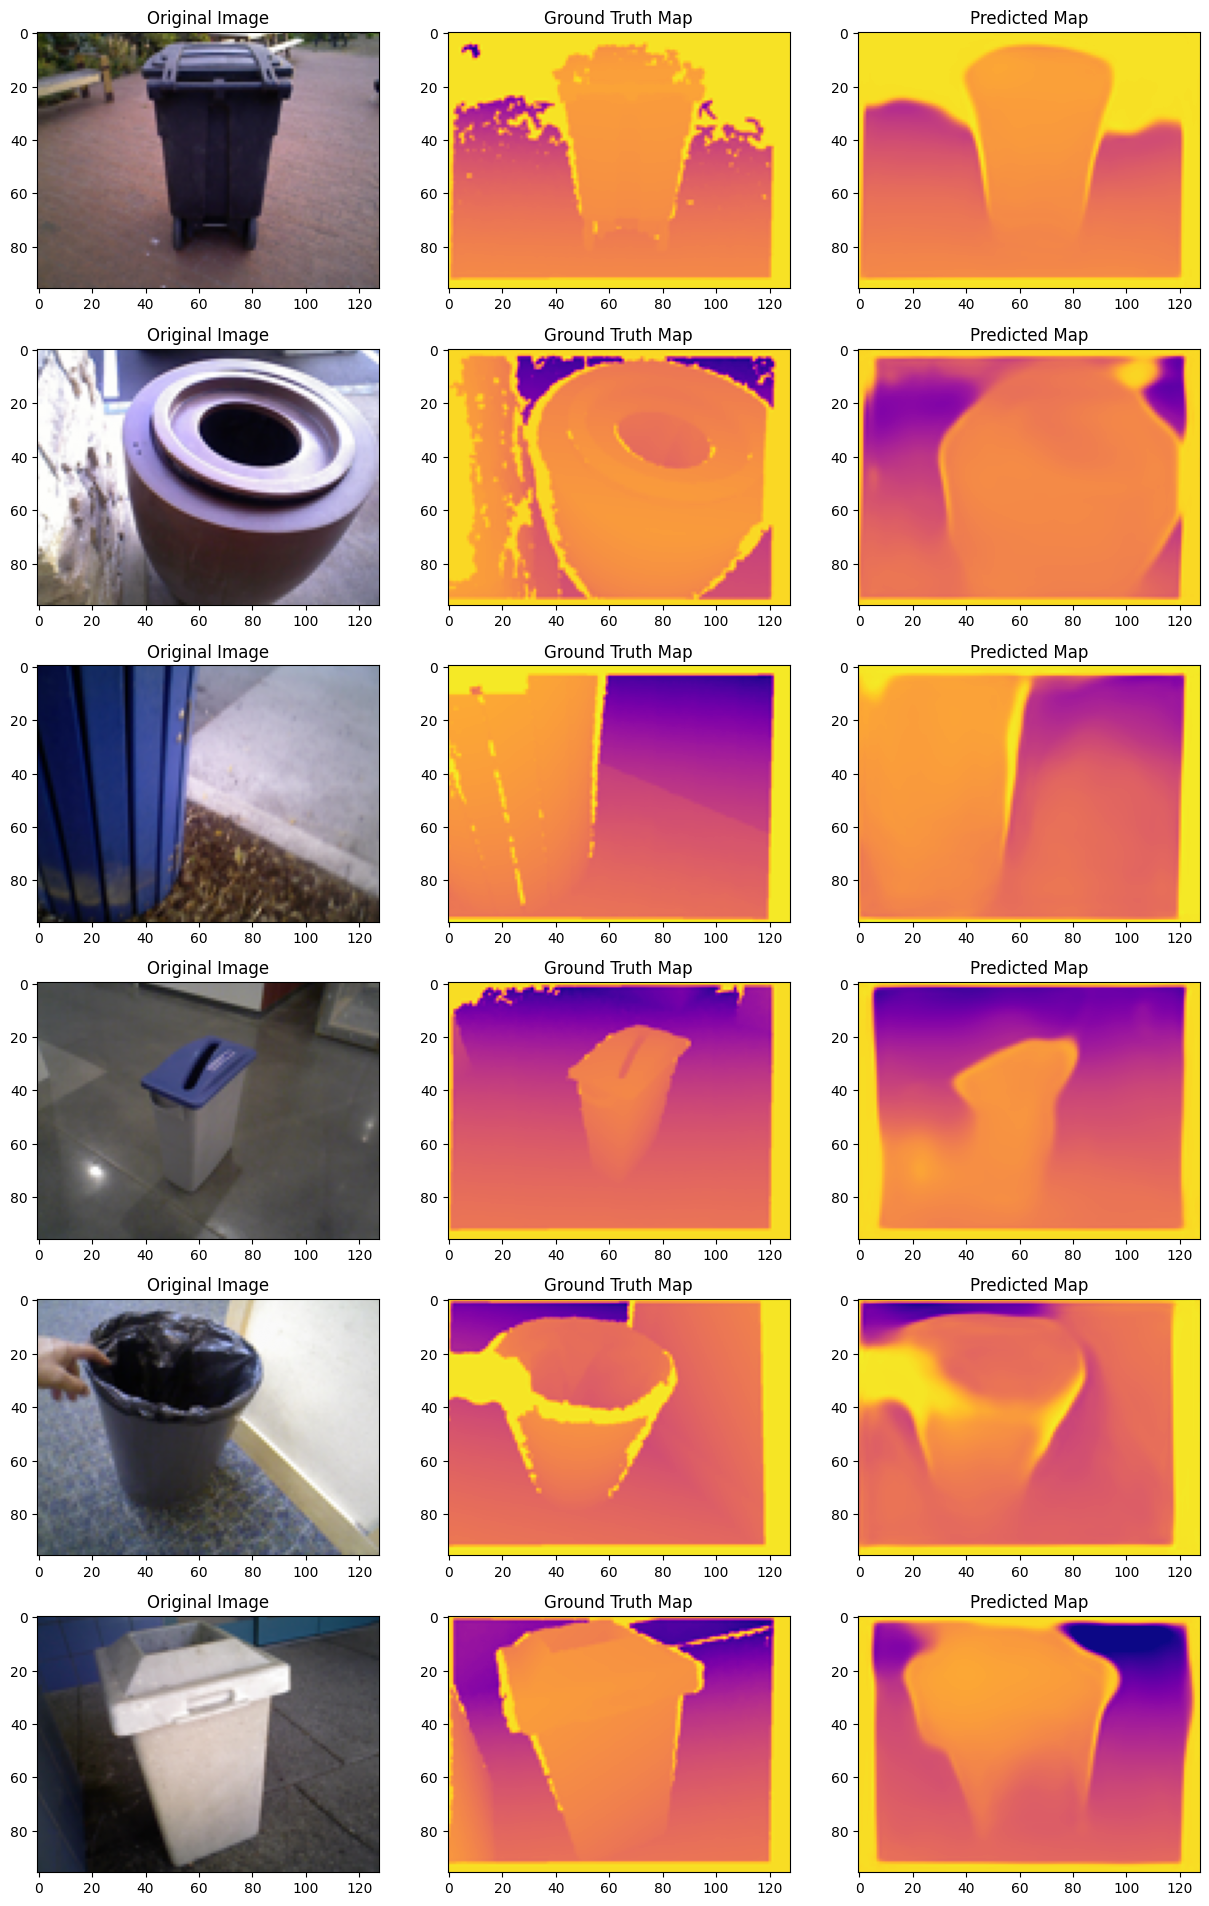

In [ ]:
show_predictions(X_test, Y_test, nums=[334, 1, 252, 3, 50, 10])